# Multiplicity determination with super-basic Bayesian Statistics

In [1]:
import numpy as np
import pandas as pd

## Example Fit / Calibration

In [2]:
class Bayes:
    def __init__(self, train, max_neutrons, label):
        # Hypotheses: Zero to max neutrons
        self._hypos = range(0, max_neutrons + 1)

        # 'Fit' -> Create PDF for all numbers of neutrons
        # TODO: Should they be normalized?
        self._hits = {
            h: np.histogram(
                train[train[label] == h]["nHits"],
                range=(0, 300),
                bins=300,
                density=True,
            )[0]
            for h in self._hypos
        }
        self._clus = {
            h: np.histogram(
                train[train[label] == h]["nClus"],
                range=(0, 300),
                bins=300,
                density=True,
            )[0]
            for h in self._hypos
        }
        self._edep = {
            h: np.histogram(
                train[train[label] == h]["Edep"],
                range=(0, 3000),
                bins=300,
                density=True,
            )[0]
            for h in self._hypos
        }

    def predict(self, x):
        # 'Predict' -> Use PDFs to get probabilities and take the highest
        probs = [
            self._hits[h][x["nHits"]]
            * self._clus[h][x["nClus"]]
            * self._edep[h][x["Edep"].floordiv(10).astype(int)]
            for h in self._hypos
        ]
        y_pred = np.argmax(probs, axis=0)
        return y_pred

In [3]:
label = "nPH"
num_dp = 30

traindata = pd.read_pickle(f"data/training_600AMeV_{num_dp}dp.pkl")
testdata = pd.read_pickle(f"data/test_600AMeV_{num_dp}dp.pkl")
# Create one entry with zero everything to prevent NaN-PDF if no entry with LABEL=0 exists
traindata.loc[0] = [0, 0, 0, 0, 0, 0]
testdata.loc[0] = [0, 0, 0, 0, 0, 0]

model = Bayes(traindata, 5, label)
y_pred = model.predict(testdata)
y_true = testdata[label].values.ravel()

print(list(zip(y_true, y_pred))[0:50])

[(0, 0), (1, 1), (1, 2), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 2), (1, 1), (0, 0), (1, 1), (1, 2), (1, 1), (1, 1), (1, 1), (1, 1), (1, 2), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)]


## Example Prediction

In [4]:
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

bac = balanced_accuracy_score(y_true, y_pred)
print(bac)
cm = confusion_matrix(y_true, y_pred, labels=range(0, 6))
print(cm)
cmrel = confusion_matrix(y_true, y_pred, labels=range(0, 6), normalize="true")
print(cmrel)

0.7409791989865088
[[ 2364     0     0     0     0     0]
 [    0 95014  7233     3     0     0]
 [    0 15096 71180 15661    88     0]
 [    0   929 20484 59587 20440   563]
 [    0    34  2267 22784 51698 24479]
 [    0     1   131  3260 21441 65228]]
[[1.    0.    0.    0.    0.    0.   ]
 [0.    0.929 0.071 0.    0.    0.   ]
 [0.    0.148 0.698 0.154 0.001 0.   ]
 [0.    0.009 0.201 0.584 0.2   0.006]
 [0.    0.    0.022 0.225 0.511 0.242]
 [0.    0.    0.001 0.036 0.238 0.724]]


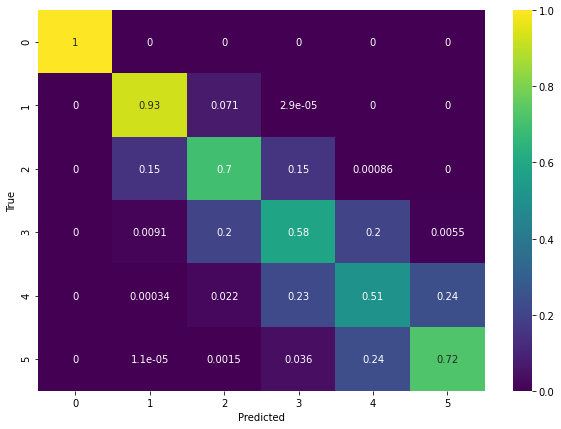

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cmrel, cmap="viridis", annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True");

## Evaluation

In [6]:
bac_scores = {}
for num_dp in [15, 30]:
    traindata = pd.read_pickle(f"data/training_600AMeV_{num_dp}dp.pkl")
    testdata = pd.read_pickle(f"data/test_600AMeV_{num_dp}dp.pkl")
    # Create one entry with zero everything to prevent NaN-PDF if no entry with LABEL=0 exists
    traindata.loc[0] = [0, 0, 0, 0, 0, 0]
    testdata.loc[0] = [0, 0, 0, 0, 0, 0]

    for n in range(2, 6):
        for label in ["nPN", "nPH"]:
            model = Bayes(traindata, n, label)
            y_pred = model.predict(testdata)
            y_true = testdata[label].values.ravel()
            bac = balanced_accuracy_score(y_true, y_pred)
            print(num_dp, n, label, bac)

15 2 nPN 0.3800931155085383
15 2 nPH 0.4329745354212018
15 3 nPN 0.4357624140537672
15 3 nPH 0.5079331137128418
15 4 nPN 0.4843344586611444
15 4 nPH 0.5714982918100472
15 5 nPN 0.527063071882835
15 5 nPH 0.6286658274830559
30 2 nPN 0.4534204900166869
30 2 nPH 0.4635447565766337
30 3 nPN 0.5532105813804225
30 3 nPH 0.5694965357902869
30 4 nPN 0.6385270425478756
30 4 nPH 0.6605582965859027
30 5 nPN 0.7132756777646793
30 5 nPH 0.7409791989865088
